# Lecture 4 Slides. Categories and Curves

https://www.youtube.com/watch?v=QiHKdvAbYII&list=PLDcUM9US4XdMROZ57-OIRtIK0aOynbgZN&index=5

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import altair as alt

# to support rendering on github
alt.renderers.enable("mimetype")

import numpy as np
np.set_printoptions(legacy="1.25")

import pandas as pd
import statreth as sr

## Load data

In [3]:
# load data
howell1 = pd.read_csv("../data/Howell1.csv", delimiter=";")
howell1_18 = howell1[howell1.age >= 18]
howell1_18.head(5)

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
height = howell1_18.height.to_numpy()
weight = howell1_18.weight.to_numpy()
gender = howell1_18.male.to_numpy()

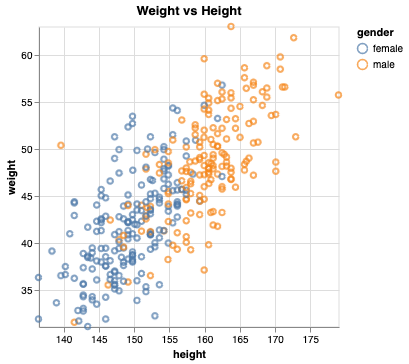

In [5]:
gender_str = [["female", "male"][g] for g in gender]
df = pd.DataFrame({"height": height, "weight": weight, "gender": gender_str})

data_chart = (
    alt.Chart(df, title="Weight vs Height")
    .mark_point()
    .encode(
        alt.X("height", scale=alt.Scale(domain=(height.min(), height.max()))),
        alt.Y("weight", scale=alt.Scale(domain=(weight.min(), weight.max()))),
        color="gender",
    )
)
data_chart

## Casual Effect of Sex on Weight?


```
Given a complete model how sex influences weight:

H──►W
▲   ▲
│   │
S───┘

Estimate total influence of sex on weight: "S->W" + "S->H->W".

IOW, what is W = f(S)?
```

In [6]:
# workaround to make stan run in jupyter
# https://pystan.readthedocs.io/en/latest/faq.html#how-can-i-use-pystan-with-jupyter-notebook-or-jupyterlab
import nest_asyncio

nest_asyncio.apply()
del nest_asyncio

from statreth.utils import suppress_subprocess_output

In [7]:
import stan

In [8]:
# model causal effect of sex on weight
code = """
data {
  int<lower=0> n;   // number of points
  vector[n] weight;
  array[n] int sex;
}
parameters {
  vector[2] alpha; // mean weight for each sex
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(60, 10);
  sigma ~ normal(10, 5);
  
  // likelihood
  weight ~ normal(alpha[sex], sigma);
}
"""

data = {"n": len(weight), "weight": weight, "sex": gender + 1}

In [9]:
%%capture
with suppress_subprocess_output():
    posterior = stan.build(code, data=data, random_seed=42)

In [10]:
%%capture
fit = posterior.sample(num_chains=4, num_samples=1000)

In [11]:
fit_df = fit.to_frame()
fit_df[["alpha.1", "alpha.2", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha.1,4000.0,41.851083,0.397839,40.392760,41.583119,41.851036,42.116019,43.555726
alpha.2,4000.0,48.608460,0.437086,47.014020,48.310968,48.614378,48.914057,50.074079
sigma,4000.0,5.536351,0.207031,4.781706,5.390710,5.534998,5.667914,6.459816


In [12]:
alpha_df = fit_df[["alpha.1", "alpha.2", "sigma"]].copy()
alpha_df = alpha_df.rename(columns={"alpha.1": "female", "alpha.2": "male"})
alpha_df.head(5)

parameters,female,male,sigma
draws,,,
0,41.748584,48.828828,5.448640
1,42.052676,48.590033,5.596700
2,41.449304,49.178357,5.434910
3,42.338986,48.397487,5.277318
4,41.920849,48.363350,5.568169


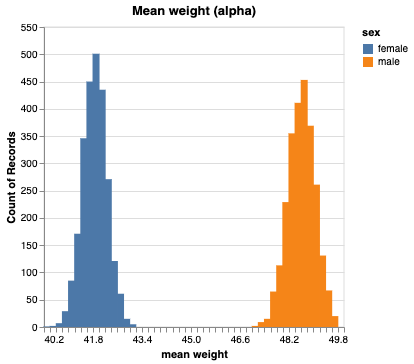

In [13]:
# plot posterior mean weight
df = alpha_df[:2500][["female", "male"]].melt(var_name="sex", value_name="alpha")

hist = (
    alt.Chart(df, title="Mean weight (alpha)")
    .mark_bar(size=7)
    .encode(
        x=alt.X("alpha", title="mean weight", bin=alt.BinParams(maxbins=70)),
        y=alt.Y("count()", stack=None),
        color="sex",
    )
)

hist

In [14]:
# sample posterior predictive
weight_female = np.random.normal(alpha_df["female"], alpha_df["sigma"])
weight_male = np.random.normal(alpha_df["male"], alpha_df["sigma"])

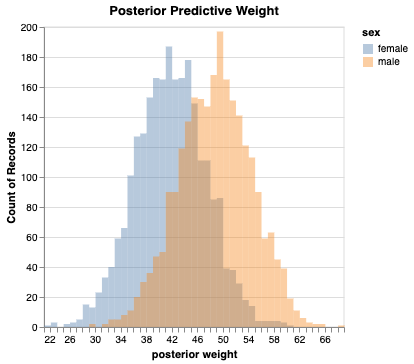

In [15]:
# plot posterior predicted weight distribution
df = pd.DataFrame({"female": weight_female, "male": weight_male})
df = df[:2500].melt(var_name="sex", value_name="weight")

hist = (
    alt.Chart(df, title="Posterior Predictive Weight")
    .mark_bar(opacity=0.4, binSpacing=0)
    .encode(
        x=alt.X("weight", title="posterior weight", bin=alt.BinParams(maxbins=50)),
        y=alt.Y("count()", stack=None),
        color="sex",
    )
)

hist

In [16]:
# calculate weight contrast difference: M - F
weight_contrast = weight_male - weight_female
print("M > F:", (weight_contrast > 0).mean())
print("M < F:", (weight_contrast < 0).mean())

M > F: 0.80975
M < F: 0.19025


In [17]:
# mean contrast
alpha_df["contrast"] = alpha_df["male"] - alpha_df["female"]

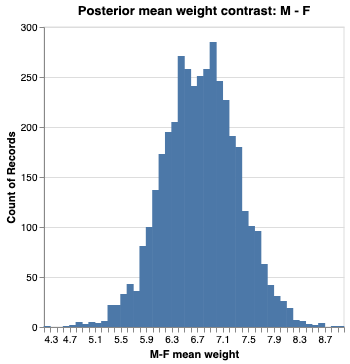

In [18]:
hist = (
    alt.Chart(alpha_df, title="Posterior mean weight contrast: M - F")
    .mark_bar(size=7)
    .encode(
        x=alt.X("contrast", title="M-F mean weight", bin=alt.BinParams(maxbins=50)),
        y="count()",
    )
)

hist

## Direct causal effect of Sex on Weight?

```
Given a complete model how sex influences weight:

H──►W
▲   ▲
│   │
S───┘

Estimate direct influence of sex on weight: only "S->W" without "S->H->W".

IOW, what is W = f(S, H)?
```

In [19]:
height_mean = height.mean()
height_mean

154.5970926136364

In [20]:
# model mean weight as a linear function of height
code = """
data {
  int<lower=0> n; // number of points
  vector[n]    weight;
  vector[n]    height;
  real         height_mean;
  array[n] int sex;
}
parameters {
  vector[2] alpha; // mean weight intercept
  vector[2] beta;  // mean weight slope
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(60, 10);
  beta ~ lognormal(0, 1);
  sigma ~ normal(10, 5);
  
  // likelihood
  for (i in 1:n) {
    real mu = alpha[sex[i]] + beta[sex[i]] * (height[i] - height_mean);
    weight[i] ~ normal(mu, sigma);
  }
}
"""

data = {
    "n": len(weight),
    "weight": weight,
    "sex": gender + 1,
    "height": height,
    "height_mean": height_mean,
}

In [21]:
%%capture
with suppress_subprocess_output():
    posterior = stan.build(code, data=data, random_seed=42)

In [22]:
%%capture
fit = posterior.sample(num_chains=4, num_samples=1000)

In [23]:
fit_df = fit.to_frame()
fit_df[["alpha.1", "alpha.2", "beta.1", "beta.2", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha.1,4000.0,45.168202,0.443797,43.566945,44.864348,45.169529,45.473753,46.673301
alpha.2,4000.0,45.101086,0.478488,43.509105,44.782123,45.100492,45.424344,46.779521
beta.1,4000.0,0.657815,0.061913,0.435298,0.615601,0.658543,0.700619,0.888460
beta.2,4000.0,0.609004,0.057216,0.398538,0.570992,0.610080,0.646739,0.829620
sigma,4000.0,4.277308,0.162451,3.773926,4.165159,4.271270,4.382836,5.034098


In [24]:
height_grid = np.linspace(height.min(), height.max(), num=50)

alpha_mean_female = fit_df["alpha.1"].mean()
alpha_mean_male = fit_df["alpha.2"].mean()

beta_mean_female = fit_df["beta.1"].mean()
beta_mean_male = fit_df["beta.2"].mean()

In [25]:
weight_mean_female = alpha_mean_female + beta_mean_female * (height_grid - height_mean)
weight_mean_male = alpha_mean_male + beta_mean_male * (height_grid - height_mean)

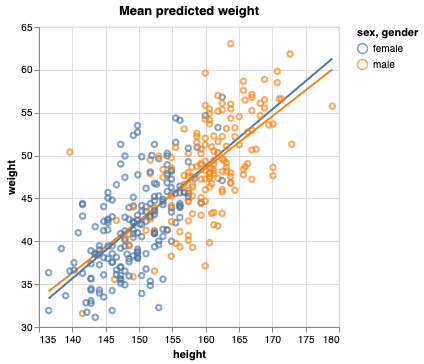

In [26]:
# plot posterior mean regression lines
df = pd.DataFrame(
    {"height": height_grid, "female": weight_mean_female, "male": weight_mean_male}
)
df = df.melt("height", var_name="sex", value_name="weight")

lines_chart = (
    alt.Chart(df, title="Mean predicted weight")
    .mark_line(strokeWidth=2)
    .encode(x="height", y=alt.Y("weight", scale=alt.Scale(zero=False)), color="sex")
)

lines_chart + data_chart

In [27]:
# plot difference (contrast) in posterior mean weight between male and female at each height value
rows = []
# probability interval masses
probs = [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for h in height_grid:
    alpha_female = fit_df["alpha.1"]
    alpha_male = fit_df["alpha.2"]

    beta_female = fit_df["beta.1"]
    beta_male = fit_df["beta.2"]

    mu_female = alpha_female + beta_female * (h - height_mean)
    mu_male = alpha_male + beta_male * (h - height_mean)

    # F - M
    contrast = mu_female - mu_male
    row = {"height": h}

    # calculate probability intervals
    for i, mass in enumerate(probs):
        low, high = sr.pi(contrast, mass)
        row[f"low_{i}"] = low
        row[f"high_{i}"] = high

        rows.append(row)

df = pd.DataFrame(rows)

In [28]:
from functools import reduce

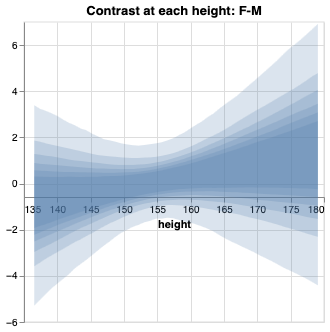

In [29]:
bands = []

for i, _ in enumerate(probs):
    band = (
        alt.Chart(df, title="Contrast at each height: F-M")
        .encode(x=alt.X("height", axis=alt.Axis(offset=-125)))
        .mark_area(opacity=0.2)
        .encode(alt.Y(f"high_{i}", axis=alt.Axis(title=None)), alt.Y2(f"low_{i}"))
    )
    bands.append(band)

reduce(lambda a, b: a + b, bands)

## Full Luxury Bayes

In [30]:
# Estimate casual effects using one general model
code = """
data {
  int<lower=0> n;
  vector[n] weight;
  vector[n] height;
  array[n] int sex;
  real height_mean;
}
parameters {
  vector[2] alpha_w;
  vector[2] beta_w;
  vector[2] alpha_h;
  real<lower=0> sigma_w;
  real<lower=0> sigma_h;
}
model {
  // height
  alpha_h ~ normal(160, 10);
  sigma_h ~ normal(10, 5);

  vector[n] nu = alpha_h[sex];
  height ~ normal(nu, sigma_h);
  
  // weight
  alpha_w ~ normal(60, 10);
  beta_w ~ lognormal(0, 1);
  sigma_w ~ normal(10, 5);
  
  vector[n] mu;
  for (i in 1:n) {
    mu[i] = alpha_w[sex[i]] + beta_w[sex[i]] * (height[i] - height_mean);
  }
  
  weight ~ normal(mu, sigma_w);
}
"""

data = {
    "n": len(weight),
    "weight": weight,
    "sex": gender + 1,
    "height": height,
    "height_mean": height_mean,
}

In [31]:
%%capture
with suppress_subprocess_output():
    posterior = stan.build(code, data=data, random_seed=42)

In [32]:
%%capture
fit = posterior.sample(num_chains=4, num_samples=1000)

In [33]:
fit_df = fit.to_frame()

In [34]:
fit_df[
    [
        "alpha_w.1",
        "alpha_w.2",
        "beta_w.1",
        "beta_w.2",
        "alpha_h.1",
        "alpha_h.2",
        "sigma_w",
        "sigma_h",
    ]
].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha_w.1,4000.0,45.162682,0.432826,43.571782,44.878706,45.165562,45.450331,47.018176
alpha_w.2,4000.0,45.091729,0.470973,43.380109,44.782222,45.089936,45.419556,46.579935
beta_w.1,4000.0,0.656364,0.060595,0.406978,0.616213,0.656953,0.697476,0.904195
beta_w.2,4000.0,0.609840,0.056710,0.401714,0.571696,0.609649,0.647327,0.810589
alpha_h.1,4000.0,149.529729,0.400498,147.738028,149.260145,149.530083,149.798428,150.892825
alpha_h.2,4000.0,160.355883,0.431925,158.561693,160.063058,160.354238,160.655269,162.077596
sigma_w,4000.0,4.275786,0.164060,3.698583,4.163564,4.271666,4.380888,4.961101
sigma_h,4000.0,5.568945,0.212314,4.857937,5.426357,5.564060,5.703449,6.451364


### Simulate synthetic people

In [35]:
n = int(1e4)

In [36]:
# females
alpha_h_female = fit_df["alpha_h.1"]
sigma_h = fit_df["sigma_h"]
syn_height_female = np.random.normal(alpha_h_female, sigma_h)  # simulate female heights

alpha_w_female = fit_df["alpha_w.1"]
beta_w_female = fit_df["beta_w.1"]
sigma_w = fit_df["sigma_w"]
mu_female = alpha_w_female + beta_w_female * (syn_height_female - height_mean)
syn_weight_female = np.random.normal(mu_female, sigma_w)  # simulate female weights

In [37]:
# males
alpha_h_male = fit_df["alpha_h.2"]
sigma_h = fit_df["sigma_h"]
syn_height_male = np.random.normal(alpha_h_male, sigma_h)  # simulate male heights

alpha_w_male = fit_df["alpha_w.2"]
beta_w_male = fit_df["beta_w.2"]
sigma_w = fit_df["sigma_w"]
mu_male = alpha_w_male + beta_w_male * (syn_height_male - height_mean)
syn_weight_male = np.random.normal(mu_male, sigma_w)  # simulate male weights

### Total casual effect of S on W

In [38]:
weight_do_sex = syn_weight_male - syn_weight_female

In [39]:
print("M > F:", (weight_do_sex > 0).mean())
print("M < F:", (weight_do_sex < 0).mean())

M > F: 0.808
M < F: 0.192


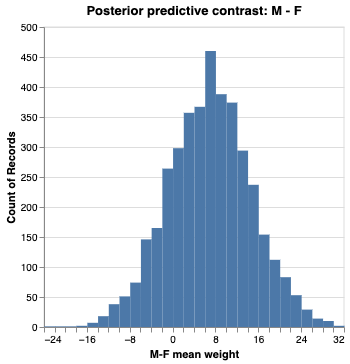

In [40]:
df = pd.DataFrame({"weight_do_sex": weight_do_sex})

hist = (
    alt.Chart(df, title="Posterior predictive contrast: M - F")
    .mark_bar(binSpacing=0)
    .encode(
        x=alt.X(
            "weight_do_sex", title="M-F mean weight", bin=alt.BinParams(maxbins=50)
        ),
        y="count()",
    )
)

hist

### Direct casual effect of S on W

In [41]:
rows = []
# probability interval masses
probs = [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for h in height_grid:
    mu_female = alpha_w_female + beta_w_female * (h - height_mean)
    mu_male = alpha_w_male + beta_w_male * (h - height_mean)

    # F - M
    contrast = mu_female - mu_male
    row = {"height": h}

    # populare probability intervals
    for i, mass in enumerate(probs):
        low, high = sr.pi(contrast, mass)
        row[f"low_{i}"] = low
        row[f"high_{i}"] = high

        rows.append(row)

df = pd.DataFrame(rows)

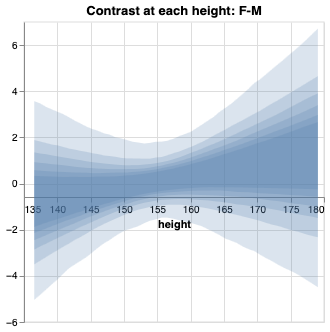

In [42]:
bands = []

for i, _ in enumerate(probs):
    band = (
        alt.Chart(df, title="Contrast at each height: F-M")
        .encode(x=alt.X("height", axis=alt.Axis(offset=-125)))
        .mark_area(opacity=0.2)
        .encode(alt.Y(f"high_{i}", axis=alt.Axis(title=None)), alt.Y2(f"low_{i}"))
    )
    bands.append(band)

reduce(lambda a, b: a + b, bands)

## Splines

Other resources:
* https://mc-stan.org/users/documentation/case-studies/splines_in_stan.html

In [43]:
import scipy.interpolate as si

In [44]:
# load data
height = howell1["height"].to_numpy()
weight = howell1["weight"].to_numpy()

sort_indices = weight.argsort()
weight = weight[sort_indices]
height = height[sort_indices]

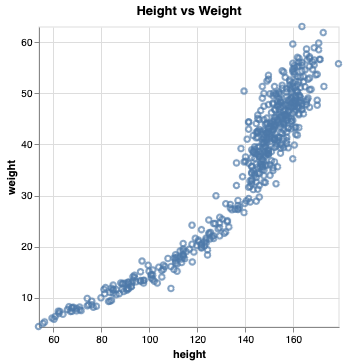

In [45]:
df = pd.DataFrame({"height": height, "weight": weight})

data_chart = (
    alt.Chart(df, title="Height vs Weight")
    .mark_point()
    .encode(
        alt.X("height", scale=alt.Scale(domain=(height.min(), height.max()))),
        alt.Y("weight", scale=alt.Scale(domain=(weight.min(), weight.max()))),
    )
)
data_chart

### Generate spline basis points

In [46]:
k = 3  # degree
knots = np.quantile(height, np.linspace(0, 1, num=10)) # (10,)
n_knots = len(knots) + k - 1
print("n_knots:", n_knots)

# repeat edge values
knots = np.pad(knots, (k, k), mode="edge") # [1,2,3] => [1,1,1, 1,2,3, 3,3,3]

n_knots: 12


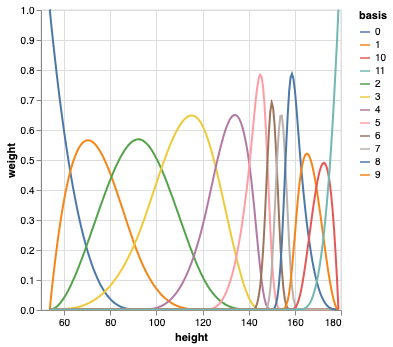

In [47]:
height_grid = np.linspace(height.min(), height.max(), num=200)
# generate points for each basis function
bpoints = si.BSpline(knots, np.eye(n_knots), k=k)(height_grid).T  # (n_knots, n_samples)

df = pd.DataFrame({"weight": [], "height": [], "basis": []})
for i, b in enumerate(bpoints):
    update_df = pd.DataFrame(
        {
            "height": height_grid,
            "weight": b,
            # `dtype=str` would incorrectly store `11` as `"1"`
            "basis": np.full_like(b, str(i), dtype=object),
        }
    )

    df = pd.concat([df, update_df], ignore_index=True)

basis_chart = alt.Chart(df).mark_line().encode(x="height", y="weight", color="basis")
basis_chart

### Fit model

sample prior

In [48]:
# generate values for each basis function
bpoints = si.BSpline(knots, np.eye(n_knots), k=k)(height).T  # (n_knots, n_samples)
bpoints.shape

(12, 544)

In [49]:
code = """
data {
  int<lower=0> n;
  int<lower=0> n_knots;
  // vector[n] weight;
  matrix[n_knots, n] bpoints;
}
parameters {
  row_vector[n_knots] coeffs; // spline coefficients
  real<lower=0> tau;          // spline scale
  real<lower=0> alpha;        // mean weight
  real<lower=0> sigma;        // weight variance
}
transformed parameters {
  vector[n] mu = alpha + to_vector(tau * coeffs * bpoints);
}
model {
  coeffs ~ normal(0, 1);
  tau ~ normal(60, 10);
  alpha ~ normal(40, 10);
  sigma ~ normal(20, 10);
  
  // weight ~ normal(mu, sigma);
}
"""

data = {"n": len(height), "n_knots": n_knots, "bpoints": bpoints}

In [50]:
%%capture
with suppress_subprocess_output():
    prior = stan.build(code, data=data, random_seed=42)

In [51]:
%%capture
prior_fit = prior.sample(num_chains=4, num_samples=1000)

In [52]:
prior_fit_df = prior_fit.to_frame()
prior_fit_df[["alpha", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha,4000.0,39.883667,10.094414,7.169988,33.160082,40.018495,46.658545,75.760898
sigma,4000.0,20.839571,9.289767,0.048802,14.125693,20.557403,26.914173,59.589462


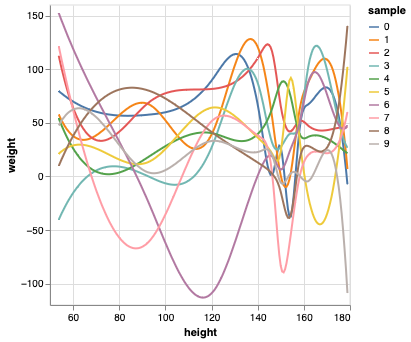

In [53]:
n_curves = 10

coeffs = prior_fit.get("coeffs")
alpha = prior_fit.get("alpha")[0]
tau = prior_fit.get("tau")[0]
df = pd.DataFrame({"weight": [], "height": [], "sample": []})
for i in range(10):
    c = coeffs[:, i]
    b = si.BSpline(knots, c, k=k)(height_grid).T
    y = alpha[i] + tau[i] * b

    update_df = pd.DataFrame(
        {
            "height": height_grid,
            "weight": y,
            "sample": np.full_like(height_grid, str(i), dtype=object),
        }
    )

    df = pd.concat([df, update_df], ignore_index=True)

prior_chart = alt.Chart(df).mark_line().encode(x="height", y="weight", color="sample")
prior_chart

Prior samples contain negative values which we could avoid by setting more correct priors

fit the model

In [54]:
code = """
data {
  int<lower=0> n;
  int<lower=0> n_knots;
  vector[n] weight;
  matrix[n_knots, n] bpoints;
}
parameters {
  row_vector[n_knots] coeffs; // spline coefficients
  real<lower=0> tau;          // spline scale
  real<lower=0> alpha;        // mean weight
  real<lower=0> sigma;        // weight variance
}
transformed parameters {
  vector[n] mu = alpha + to_vector(tau * coeffs * bpoints);
}
model {
  coeffs ~ normal(0, 1);
  tau ~ normal(60, 10);
  alpha ~ normal(120, 20);
  sigma ~ normal(25, 15);
  
  weight ~ normal(mu, sigma);
}
"""

data = {"n": len(height), "n_knots": n_knots, "weight": weight, "bpoints": bpoints}

In [55]:
%%capture
with suppress_subprocess_output():
    posterior = stan.build(code, data=data, random_seed=42)

In [56]:
%%capture
fit = posterior.sample(num_chains=4, num_samples=1000)

In [57]:
fit_df = fit.to_frame()
fit_df[["alpha", "tau", "sigma", "coeffs.1", "coeffs.2"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha,4000.0,60.553447,12.689035,15.709172,51.488026,60.089684,69.374135,102.771286
tau,4000.0,48.785497,10.227757,20.352880,41.752300,48.465183,55.435470,90.578226
sigma,4000.0,3.798217,0.114647,3.406003,3.718350,3.796857,3.876942,4.204993
coeffs.1,4000.0,-1.156805,0.251765,-2.193851,-1.316752,-1.143090,-0.989491,-0.208202
coeffs.2,4000.0,-1.126985,0.249774,-2.058700,-1.280471,-1.118214,-0.961501,-0.127241


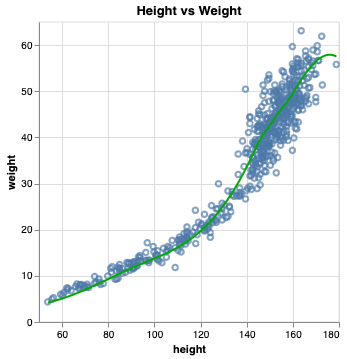

In [58]:
coeffs = fit.get("coeffs")
coeffs = coeffs.mean(axis=1)

alpha = fit.get("alpha").mean()
tau = fit.get("tau").mean()

b = si.BSpline(knots, c=coeffs, k=k)(height_grid).T
mean_pred_weight = alpha + tau * b

df = pd.DataFrame({"height": height_grid, "weight": mean_pred_weight})

mean_pred_weight_chart = (
    alt.Chart(df, title="Mean predicted height")
    .mark_line(strokeWidth=2, color="#00AA00")
    .encode(x="height", y="weight")
)
data_chart + mean_pred_weight_chart